In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from qnetwork.tools import set_plot_style
from experiment_4 import exp004,estimate_frequency_fft,estimate_frequency_L2,estimate_frequency_corr
from aux_funs import run_ww_simulation,DDE_analytical


#set_plot_style()

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  

# 1. Rabi-like behavior estimation

Because we include many modes, we no longer have a single-mode dynamics, but rather quasi-periodical behavior. for this reason, we need to estimate the 'frequency' of this quasi-oscillations. We have some ways to do this. Namely; 
1. fast fourier transform technique.
2. Minimize $L^{2}$-error technique. 
3. self-correlation technique.

From those, the fastest (and simingly best working) option is number 2. 

## 1.1 Different methods 

estimation using fft: 0.22172313337065977
estimation using L2 error: [0.22194168]
estimation using self correlation: 0.22200127827750327


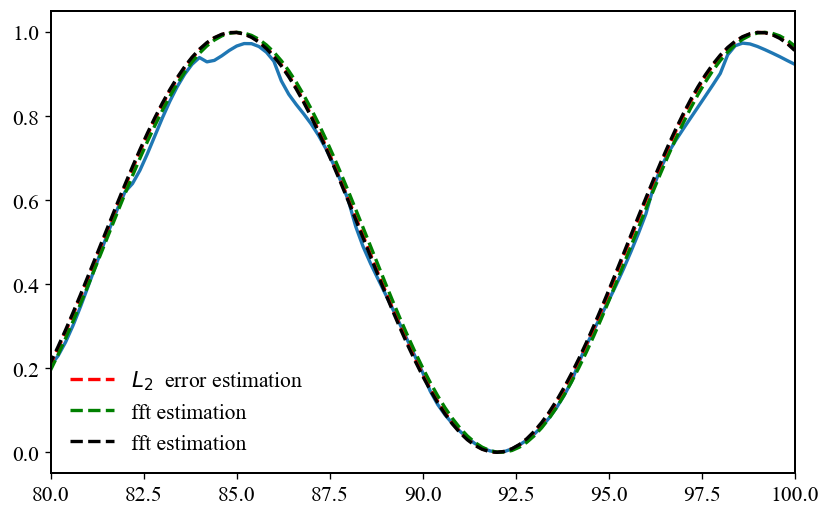

In [2]:
w_L2=estimate_frequency_L2()
w_fft =estimate_frequency_fft()
w_corr=estimate_frequency_corr()
t,e = run_ww_simulation(t_max=100,n_steps=501)

print('estimation using fft: ' + str(w_fft))
print('estimation using L2 error: ' + str(w_L2))
print('estimation using self correlation: ' + str(w_corr))

plt.plot(t,e)
plt.plot(t,np.cos(w_L2*t)**2,'r--',label=r"$L_{2}$  error estimation")
plt.plot(t,np.cos(w_fft*t)**2,'g--',label='fft estimation')
plt.plot(t,np.cos(w_corr*t)**2,'k--',label='fft estimation')
plt.xlim(80,100)
plt.legend()
plt.grid()
plt.show()


## 1.2 Spectral response Vs $\gamma , \Delta $ 

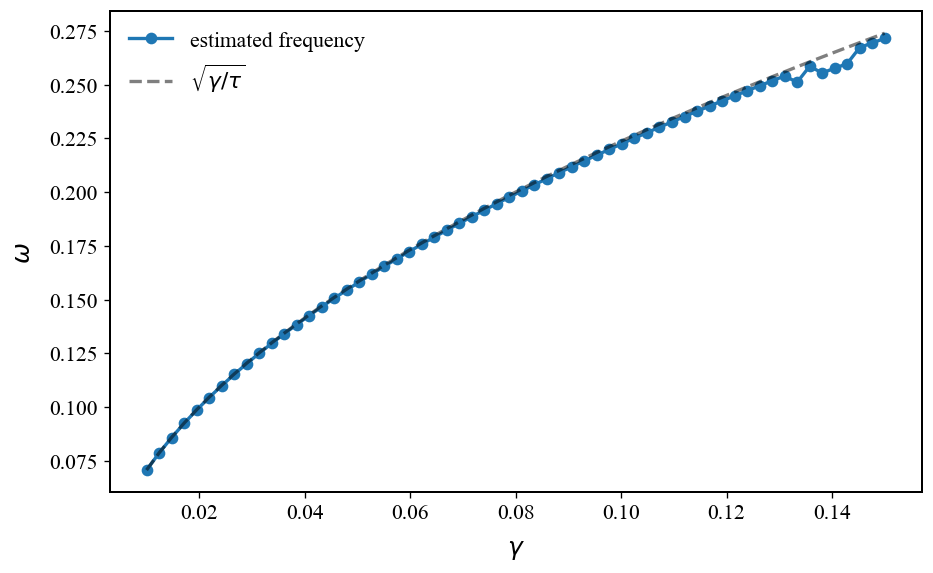

In [ ]:
_=exp004(Delta_list=[10],gamma_list=list(np.linspace(0.01,0.15,60)),L2_method='TNC',n_steps=1001,n_modes=70)

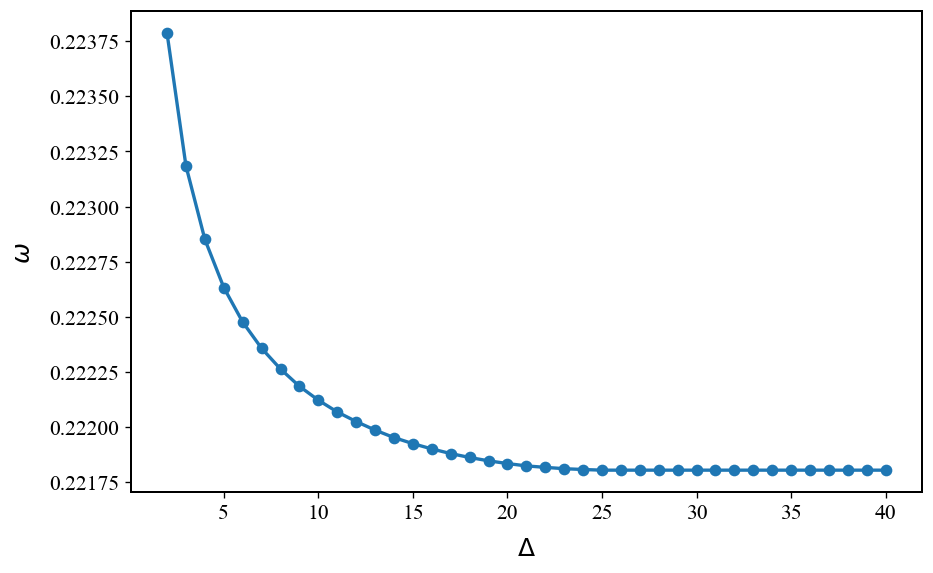

In [ ]:
_ = exp004(gamma_list=[0.1],Delta_list=list(range(2,41,1)),n_steps=1001,L2_method='L-BFGS-B')

# 2. Avoided level crossing 

In [50]:
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from aux_funs import average_fft,DDE_analytical,paralelizar
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import interp1d



def exp005(gamma:float=0.1,
		   tau: float = 1,
		   phi_range: list = list(np.linspace(-4*np.pi,4*np.pi,300)),
		   t_max: float = 100,
		   n_points: int = 10500,
		   Ms: list = list(np.arange(10000,10061,1))
		   ):
	''' This is the spectral response of the QUBIT'S EXCITED STATE, NOT THE A_OUT. 
	'''
	
	t = np.linspace(0,t_max,n_points)

	def a_in(J_0,phi):
		N = int(t[-1]/tau)
		Delta = phi/tau
		J = np.exp(1j*Delta*t)*J_0

		a = np.sqrt(gamma)*J
		J_inter = interp1d(x=t,y=J,bounds_error=False, fill_value=0)
		for n in range(1,N):
			a+= np.sqrt(gamma)*np.exp(1j*n*phi)*J_inter(t-n*tau)*np.heaviside(t-n*tau,0)
		return a
			
	def sample_phi(phi):
		J = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
		a = a_in(J_0=J,phi=phi)
		w,u = average_fft(x=t,y=a,Ms=Ms)
		I = np.abs(u)**2
		return [w,I]
	
	data = paralelizar(phi_range,sample_phi)
	w = np.real(np.asarray(data)[0,0,:])
	u = np.abs(np.asarray(data)[:,1,:])

	w_ref = np.linspace(-3*np.pi,3*np.pi,1000)
	u_shift = []

	for n,phi in enumerate(phi_range):
		interp = interp1d(x=w-phi/tau,y=u[n,:])
		u_shift.append(interp(w_ref))

	u_map = np.asarray(u_shift)
	w_min = w_ref[0]
	w_max = w_ref[-1]

	w_res,I_res = sample_phi(0)

	fig,ax =plt.subplots(figsize=(7, 4))

	im = ax.imshow(
		u_map.T,
		cmap='Blues',
		origin='lower',
		extent=[w_max/np.pi, w_min/np.pi,
				phi_range[0]/np.pi, phi_range[-1]/np.pi],
		aspect='auto',
		norm=PowerNorm(gamma=0.32),
					)
	cbar = fig.colorbar(im, ax=ax)
	cbar.set_label(r"Arbitrary Units ")
	cbar.formatter = FuncFormatter(lambda x, pos: f"{x/1000:.1f}")
	cbar.update_ticks()

	ax.set_ylabel(r"$\nu \tau / \pi$")
	ax.set_xlabel(r"$\phi / \pi$")
	ax.axvline(x=0,linestyle='dashdot',color='gray',alpha=0.5)
	ax.invert_xaxis()

	axins = inset_axes(
    ax,
    width="35%", height="35%",
    loc="upper left",
    bbox_to_anchor=(0.05, 0.08, 0.9, 0.9),
    bbox_transform=ax.transAxes
						)

	axins.plot(w_res/np.pi,I_res/1000)
	axins.set_xlim(-2.5,2.5)
	axins.set_xlabel(r"$\nu \tau / \pi $")

	
	plt.show()
	
	

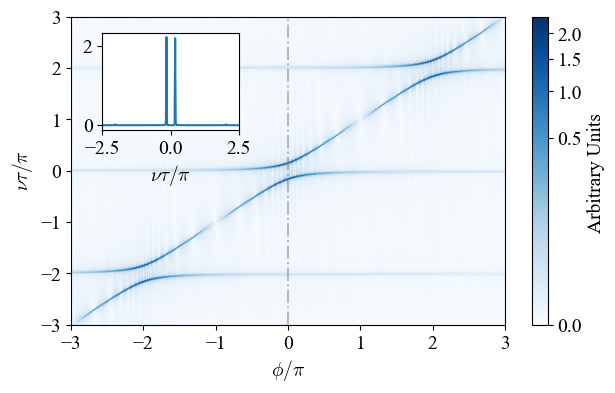

In [51]:
exp005(gamma=0.25,phi_range =list(np.linspace(-3*np.pi,3*np.pi,600)))

(-10.0, 10.0)

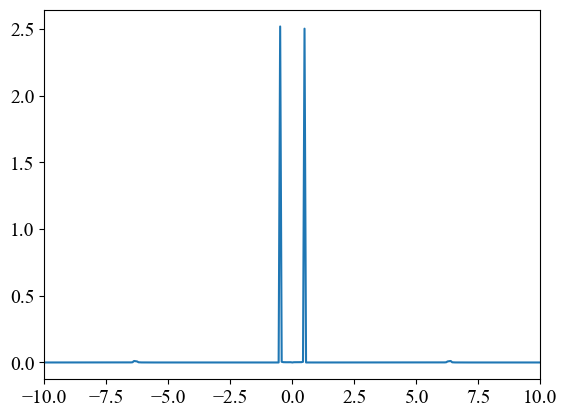

In [35]:
gamma = 0.25
tau =1 
t_max=102
n_steps=15000

t = np.linspace(0,t_max,n_steps)
Ms: list = list(np.arange(15000,15051,1))

def a_in(J_0,phi):
	N = int(t[-1]/tau)
	Delta = phi/tau
	J = np.exp(1j*Delta*t)*J_0

	a = np.sqrt(gamma)*J
	J_inter = interp1d(x=t,y=J,bounds_error=False, fill_value=0)
	for n in range(1,N):
		a+= np.sqrt(gamma)*np.exp(1j*n*phi)*J_inter(t-n*tau)*np.heaviside(t-n*tau,0)
	return a
		
def sample_phi(phi):
	J = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
	a = a_in(J_0=J,phi=phi)
	w,u = average_fft(x=t,y=a,Ms=Ms)
	I = np.abs(u)**2
	return [w,I]

w_res,I_res = sample_phi(0)
plt.plot(w_res,I_res/1000)
plt.xlim(-10,10)


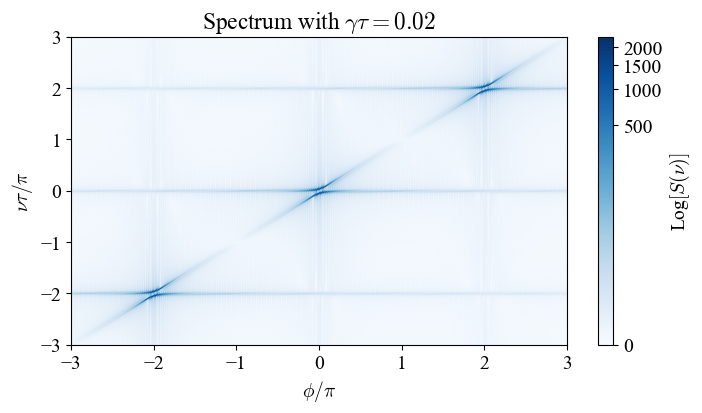

In [ ]:
exp005(gamma=0.02,phi_range =list(np.linspace(-3*np.pi,3*np.pi,800)))

# 3. Fidelity 

Now, let's see how good the revivals are as we change the system. 
the bottom line is that, for high enough $\Delta$, you don't need to worry about lambshift. so, for now, I will just vary the coupling strength. 

In [ ]:
from aux_funs import paralelizar
def exp006(phi: float = 2*np.pi,
		   tau: float = 2, 
		   gamma_list: list = list(np.linspace(0.01,0.1,20)),
		   n_steps: int = 201,
		   ):
	''' This experiment shows the fidelity in the first period '''

	def sample_gamma(gamma):
		T = 2*np.pi*np.sqrt(tau/gamma)
		t_max= 1.2*T 
		t = np.linspace(0,t_max,n_steps)
		e = np.abs(DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t))**2
		return np.max(e[t>5*T/6])
	
	data= paralelizar(gamma_list,sample_gamma)
	inf=1-np.asarray(data)
	plt.plot(gamma_list,inf)
	plt.yscale('log')
	plt.xscale('log')
	plt.xlabel(r"$ \gamma  $")
	plt.ylabel(r"$1-\mathcal{F}$")
	plt.show()
	
	return gamma_list,inf 


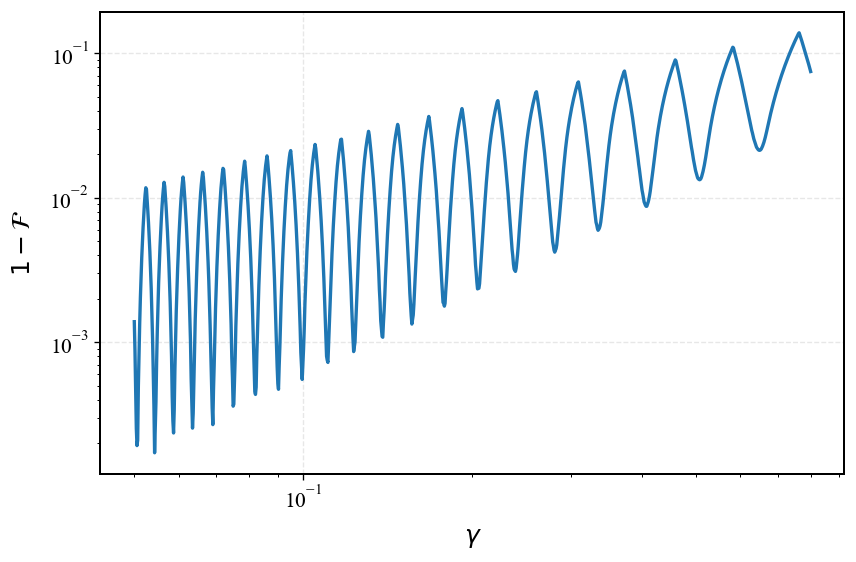

In [35]:
x,y = exp006(gamma_list=list(np.logspace(-1.301,-0.0969,1000)),n_steps=10001,tau=1)

In [120]:
data = np.loadtxt('infidelity_vs_gamma_from_plot.csv',delimiter=',',skiprows=0)

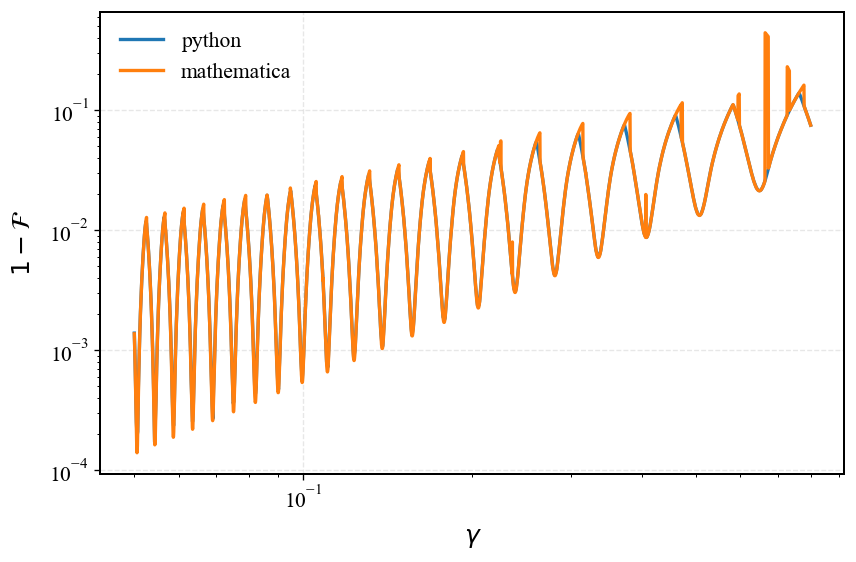

In [144]:
x_data = data[:,0]
y_data = data[:,1]

idx = np.argsort(x_data)

x_data= x_data[idx]
y_data = y_data[idx]

plt.plot(x,y,label='python ')
plt.plot(x_data,y_data,label='mathematica')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\gamma $")
plt.ylabel(r"$1-\mathcal{F}$")
plt.legend()
plt.show()

# Extra. Two qubits in a cavity 

In [ ]:
from experiment_two_qubits import exp_two_qubits

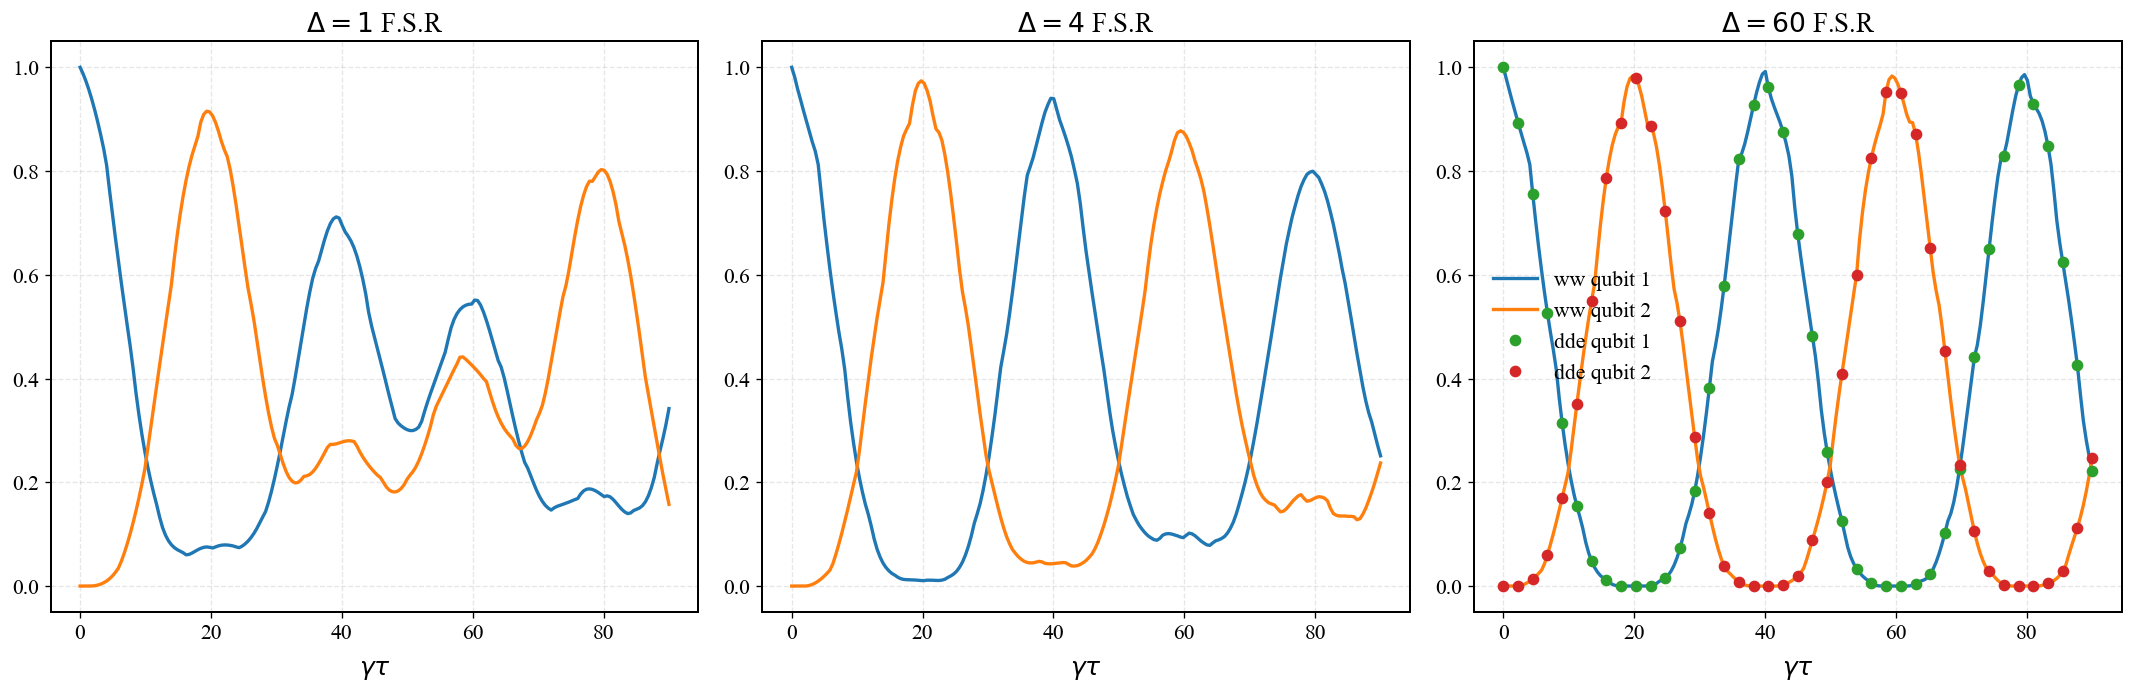

In [ ]:
exp_two_qubits(phi_list=[1*np.pi,4*np.pi,60*np.pi],gamma=0.05,t_max=90)